In [1]:
!sudo apt-get install -y fonts-nanum* | tail -n 1
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 4.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 39 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no suc

In [2]:
# 필요 라이브러리 설치

!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

In [1]:
# 라이브러리 임포트

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# 폰트 관련 용도
import matplotlib.font_manager as fm

# Colab, Linux
# 나눔 고딕 폰트의 경로 명시
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()

# Window
# font_name = "NanumBarunGothic"

# Mac
# font_name = "AppleGothic"

In [2]:
# warning 표시 끄기
import warnings
warnings.simplefilter('ignore')

# 기본 폰트 설정
plt.rcParams['font.family'] = font_name  # window font

# 기본 폰트 사이즈 변경
plt.rcParams['font.size'] = 14

# 기본 그래프 사이즈 변경
plt.rcParams['figure.figsize'] = (6,6)

# 기본 그리드 표시
# 필요에 따라 설정할 때는, plt.grid()
plt.rcParams['axes.grid'] = True
plt.rcParams["grid.linestyle"] = ":"

# 마이너스 기호 정상 출력
plt.rcParams['axes.unicode_minus'] = False

# 넘파이 부동소수점 자릿수 표시
np.set_printoptions(suppress=True, precision=4)

In [3]:
# 파이토치 관련 라이브러리

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader

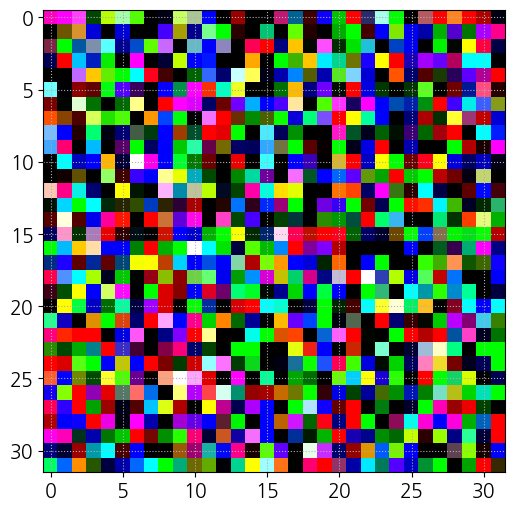

In [4]:
inputs = torch.randn(100, 3, 32, 32)
plt.imshow(inputs[0].permute(1,2,0))
plt.show()

In [5]:
conv1 = nn.Conv2d(3, 32, 3)
relu = nn.ReLU(inplace=True)
conv2 = nn.Conv2d(32, 32, 3)
maxpool = nn.MaxPool2d((2, 2))

x1 = conv1(inputs)
x2 = relu(x1)
x3 = conv2(x2)
x4 = relu(x3)
x5 = maxpool(x4)

print("x1 shape =", x1.shape)
print("x2 shape =", x2.shape)
print("x3 shape =", x3.shape)
print("x4 shape =", x4.shape)
print("x5 shape =", x5.shape)

# nn.Sequantial()

x1 shape = torch.Size([100, 32, 30, 30])
x2 shape = torch.Size([100, 32, 30, 30])
x3 shape = torch.Size([100, 32, 28, 28])
x4 shape = torch.Size([100, 32, 28, 28])
x5 shape = torch.Size([100, 32, 14, 14])


In [6]:
def torch_seed(seed=123):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

In [7]:
# 손실 계산용
def eval_loss(loader, device, net, criterion):

    # 데이터로더에서 처음 한 개 세트를 가져옴
    for images, labels in loader:
        break

    # 디바이스 할당
    inputs = images.to(device)
    labels = labels.to(device)

    # 예측 계산
    outputs = net(inputs)

    # 손실 계산
    loss = criterion(outputs, labels)

    return loss

In [8]:
# 학습용 함수
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    # tqdm 라이브러리 임포트
    from tqdm.notebook import tqdm

    base_epochs = len(history) # => 0
    batch_size_train = len(train_loader)
    batch_size_test = len(test_loader)

    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        # 훈련 페이즈
        net.train() # dropout, batch normalization 활성화
        # count = 0

        for inputs, labels in tqdm(train_loader):
            # count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 경사 초기화
            optimizer.zero_grad()

            # 예측 계산
            outputs = net(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # 경사 계산
            loss.backward()

            # 파라미터 수정
            optimizer.step()

            # 예측 라벨 산출
            predicted = torch.max(outputs, 1)[1]

            # 정답 건수 산출
            train_acc += (predicted == labels).sum().item() /len(labels)

            # 손실과 정확도 계산
        avg_train_loss = train_loss / batch_size_train
        avg_train_acc = train_acc / batch_size_train

        # 예측 페이즈
        net.eval()
        # count = 0

        for inputs, labels in test_loader:
            # count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 예측 계산
            outputs = net(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # 예측 라벨 산출
            predicted = torch.max(outputs, 1)[1]

            # 정답 건수 산출
            val_acc += (predicted == labels).sum().item() /len(labels)

            # 손실과 정확도 계산
        avg_val_loss = val_loss / batch_size_test
        avg_val_acc = val_acc / batch_size_test

        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history

In [9]:
# 학습 로그 해석

def evaluate_history(history):
    # 손실과 정확도 확인
    print(f'초기상태 : 손실 : {history[0,3]:.5f}  정확도 : {history[0,4]:.5f}')
    print(f'최종상태 : 손실 : {history[-1,3]:.5f}  정확도 : {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 학습 곡선 출력(손실)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='훈련')
    plt.plot(history[:,0], history[:,3], 'k', label='검증')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('반복 횟수')
    plt.ylabel('손실')
    plt.title('학습 곡선(손실)')
    plt.legend()
    plt.show()

    # 학습 곡선 출력(정확도)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='훈련')
    plt.plot(history[:,0], history[:,4], 'k', label='검증')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('반복 횟수')
    plt.ylabel('정확도')
    plt.title('학습 곡선(정확도)')
    plt.legend()
    plt.show()

In [10]:
# 이미지와 라벨 표시
def show_images_labels(loader, classes, net, device):

    # 데이터로더에서 처음 1세트를 가져오기
    for images, labels in loader:
        break
    # 표시 수는 50개
    n_size = min(len(images), 50)
    print("n_size = ", n_size)

    if net is not None:
      # 디바이스 할당
      inputs = images.to(device)
      labels = labels.to(device)

      # 예측 계산
      outputs = net(inputs)
      predicted = torch.max(outputs,1)[1]
      #images = images.to('cpu')

    # 처음 n_size개 표시
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        # net이 None이 아닌 경우는 예측 결과도 타이틀에 표시함
        if net is not None:
          predicted_name = classes[predicted[i]]
          # 정답인지 아닌지 색으로 구분함
          if label_name == predicted_name:
            c = 'k'
          else:
            c = 'b'
          ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        # net이 None인 경우는 정답 라벨만 표시
        else:
          ax.set_title(label_name, fontsize=20)
        # 텐서를 넘파이로 변환
        image_np = images[i].numpy().copy()
        # 축의 순서 변경 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 값의 범위를[-1, 1] -> [0, 1]로 되돌림
        img = (img + 1)/2
        # 결과 표시
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()


In [11]:
transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x:x.view(-1))
])

transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

In [12]:
data_root = './data'

train_set1 = datasets.CIFAR10(
    root = data_root,
    train = True,
    download = True,
    transform = transform1
)

test_set1 = datasets.CIFAR10(
    root = data_root,
    train = False,
    download = True,
    transform = transform1
)

train_set2 = datasets.CIFAR10(
    root = data_root,
    train = True,
    download = True,
    transform = transform2
)

test_set2 = datasets.CIFAR10(
    root = data_root,
    train = False,
    download = True,
    transform = transform2
)

100%|██████████| 170M/170M [00:03<00:00, 50.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [15]:
image1, label1 = train_set1[0]
image2, label2 = train_set2[0]

print('image1 shape', image1.shape)
print('image2 shape', image2.shape)

image1 shape torch.Size([3072])
image2 shape torch.Size([3, 32, 32])


In [17]:
batch_size = 100
train_loader1 = DataLoader(
    dataset=train_set1,
    batch_size=batch_size,
    shuffle=True
)

test_loader1 = DataLoader(
    dataset=test_set1,
    batch_size=batch_size,
    shuffle=False
)

train_loader2 = DataLoader(
    dataset=train_set2,
    batch_size=batch_size,
    shuffle=True
)

test_loader2 = DataLoader(
    dataset=test_set2,
    batch_size=batch_size,
    shuffle=False
)

In [18]:
for images2, labels2 in train_loader2:
  break

print(images2.shape)

torch.Size([100, 3, 32, 32])


In [20]:
classes = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', ' truck']

print(classes)
print(len(classes))

['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', ' truck']
10


n_size =  50


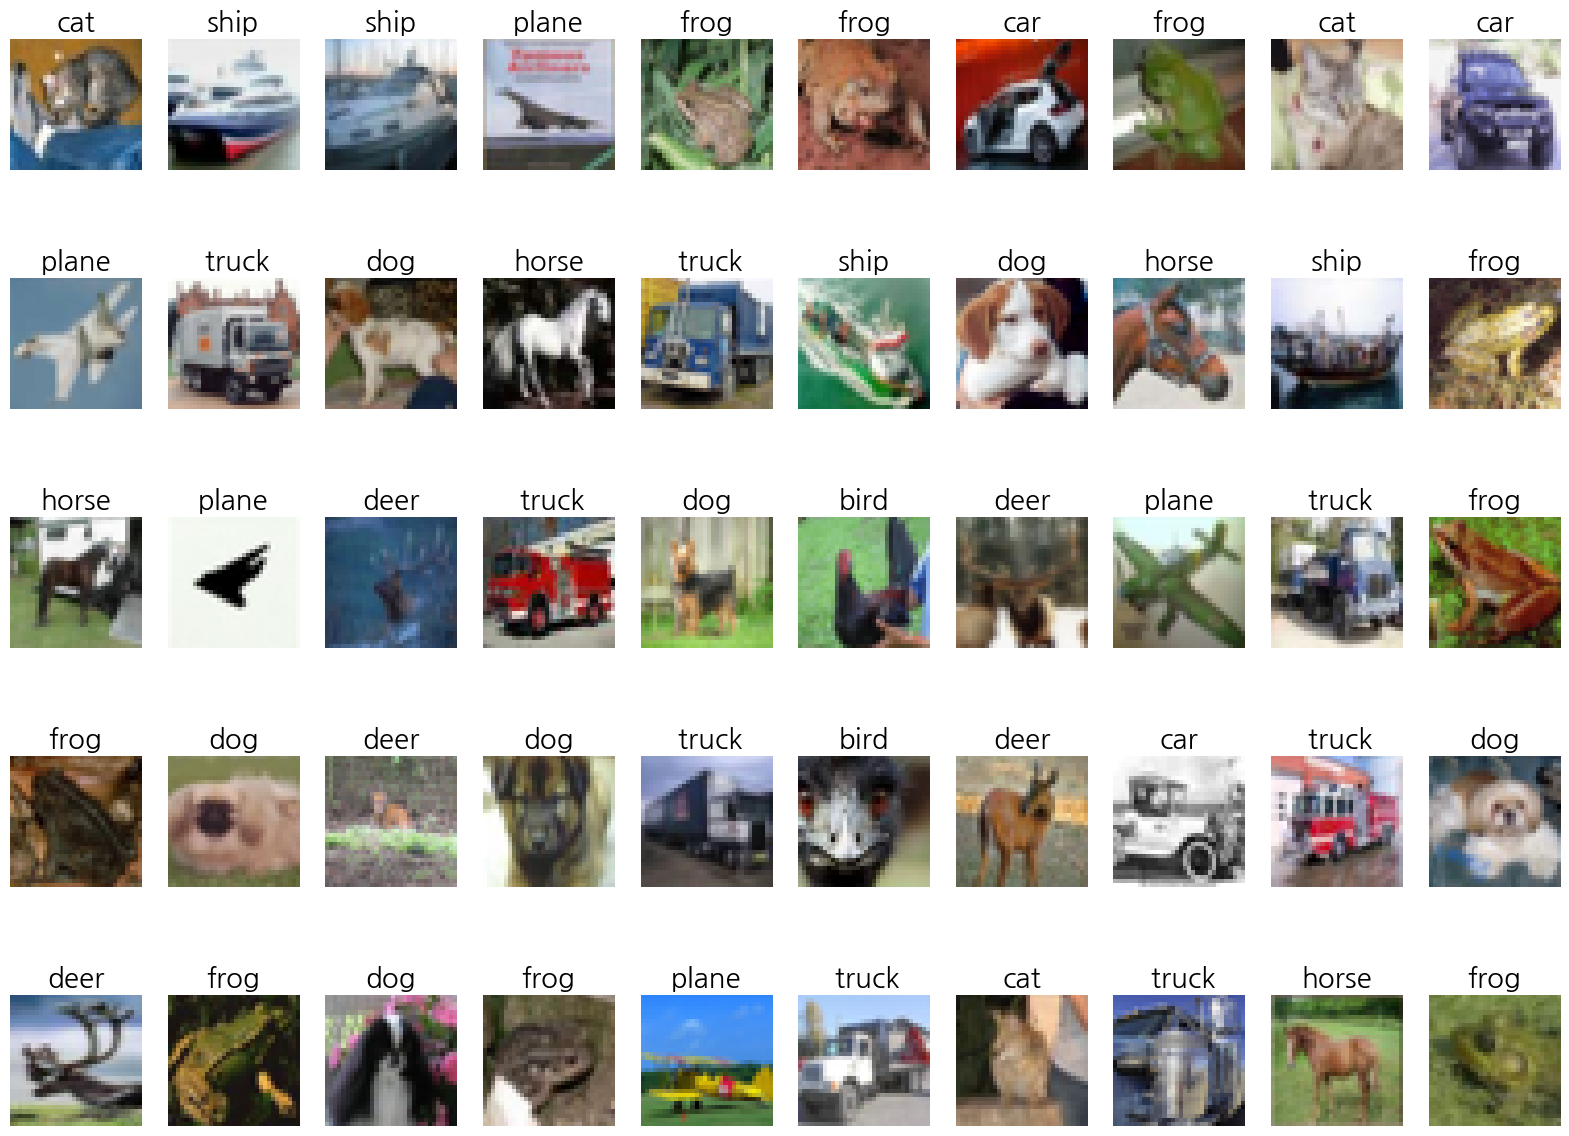

In [21]:
show_images_labels(test_loader2, classes, None, 'cpu')

In [30]:
class CNN(nn.Module):
  def __init__(self, n_output, n_hidden):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d((2, 2))
    self.flatten = nn.Flatten()

    self.l1 = nn.Linear(6272, n_hidden)
    self.l2 = nn.Linear(n_hidden, n_output)

    self.features = nn.Sequential(
        self.conv1,
        self.relu,
        self.conv2,
        self.relu,
        self.maxpool
    )

    self.classifier = nn.Sequential(
        self.l1,
        self.relu,
        self.l2
    )

  def forward(self, x):
    x1 = self.features(x)
    x2 = self.flatten(x1)
    x3 = self.classifier(x2)

    return x3

In [31]:
n_output = len(set(labels2.data.numpy()))
n_hidden = 100

print('n_output =', n_output)

net = CNN(n_output, n_hidden)
lr = 0.01
optimizer = optim.SGD(net.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

n_output = 10


In [32]:
summary(net, (100, 3, 32, 32), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [100, 10]                 --
├─Sequential: 1-1                        [100, 32, 14, 14]         9,248
│    └─Conv2d: 2-1                       [100, 32, 30, 30]         896
├─Sequential: 1-4                        --                        (recursive)
│    └─ReLU: 2-2                         [100, 32, 30, 30]         --
├─Sequential: 1-5                        --                        (recursive)
│    └─Conv2d: 2-3                       [100, 32, 28, 28]         9,248
├─Sequential: 1-4                        --                        (recursive)
│    └─ReLU: 2-4                         [100, 32, 28, 28]         --
├─Sequential: 1-5                        --                        (recursive)
│    └─MaxPool2d: 2-5                    [100, 32, 14, 14]         --
├─Flatten: 1-6                           [100, 6272]               --
├─Sequential: 1-7                        [

In [33]:
num_epochs = 10
history = np.zeros((0, 5))
history = fit(net, optimizer, criterion, num_epochs,
              train_loader2, test_loader2, 'cpu', history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/10], loss: 2.12342 acc: 0.23620 val_loss: 1.89294, val_acc: 0.33910


  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 